In [1]:
import numpy as np
import matplotlib
import time
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
import skimage.feature
from PIL import Image
import scipy.ndimage
from skimage import transform
from matplotlib.patches import Circle
from scipy.ndimage.filters import gaussian_laplace, convolve
from scipy.ndimage.filters import rank_filter, generic_filter
import matplotlib.image as mpimg
import time
import math

# Configuration

In [2]:
img_dir = 'blobs-data/'
images = ['101085','119082','182053','210088','butterfly', 'einstein', 'fishes', 'sunflowers']
initial_sigma = 2
level =11
k = 1.26
size3 = 11
threshold = 0.1

# Show pictures

In [3]:
# Code from Lana Lazebnik.
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

# Preprocess, to graysclae and float

In [4]:
def preprocess(path):
    image = (io.imread(path,as_gray=True))/255
    return image

# Build a Laplacian scale space: basic

In [5]:
def build_Laplacian_basic (image, initial_sigma, level, k):
    h = image.shape[0]
    w = image.shape[1]
    scale_space = np.empty((h,w,level))
    sigma_space = np.empty(level)
    sigma_space[0] = initial_sigma
    for i in range(level):
        scale_space[:,:,i] = (sigma_space[i]**2*gaussian_laplace(image, sigma_space[i]))**2
        if(i+1<level):
            sigma_space[i+1] = sigma_space[i]*k
    return scale_space,sigma_space

# NonMaximum Suppresion 2d: basic

In [6]:
def non_max_sup_2d (image,level,k):
    h = image.shape[0]
    w = image.shape[1]
    non_sup_2d = np.empty((h,w,level))
    scale_space_local,sigma_space = build_Laplacian_basic(image,initial_sigma,level,k)
    for i in range(level):
        image_n_slice = rank_filter(scale_space_local[:,:,i],-1,size=3)
        diff = np.max(image_n_slice)-np.min(image_n_slice)
        standard = np.min(image_n_slice)+diff*threshold
        image_n_slice = np.clip(image_n_slice,standard,None)
        mask = scale_space_local[:,:,i]==image_n_slice
        non_sup_2d[mask,i] = image_n_slice[mask]
    return non_sup_2d

# NonMaximum Suppresion 2d: efficient

In [7]:
def non_max_sup_2d_effi(image,level,k,isDOG,threshold):
    h = image.shape[0]
    w = image.shape[1]
    non_sup_2d = np.zeros((h,w,level))
    a=1
    if isDOG==True:
        scale_space_local = build_Laplacian_DOG(image, initial_sigma, level, k)
    elif isDOG==False:
        scale_space_local = build_Laplacian_efficient(image,initial_sigma,level,k)                               
    for i in range(level):
        image_n_slice = rank_filter(scale_space_local[i],-1,size=3)
        diff = np.max(image_n_slice)-np.min(image_n_slice)
        standard = np.min(image_n_slice)+diff*threshold
        image_n_slice = np.clip(image_n_slice,standard,None)
        m_2d = np.where(scale_space_local[i]==image_n_slice)
        x1 = (a*m_2d[1])
        y1 = (a*m_2d[0])
        col = x1.astype(int)
        row = y1.astype(int)
        if(i<level-1):
            a = a*k
        non_sup_2d[row,col,i] = image_n_slice[m_2d]
    return non_sup_2d

# NonMaximum Suppresion 3d: basic

In [8]:
def non_max_sup_3d (non_sup_2d, initial_sigma,k, size3,threshold):
    scale_space = rank_filter(non_sup_2d,-1,size=size3)
    diff = np.max(scale_space)-np.min(scale_space)
    standard = np.min(scale_space)+diff*threshold
    scale_space  = np.clip(scale_space,standard,None)
    m = np.where(non_sup_2d==scale_space)
    s = m[2]
    rad = (initial_sigma*k**s)*(2**0.5)
    return m[1],m[0],rad

# Run Detection: basic

In [9]:
def run_detection(img_name,initial_sigma,level,k,threshold,size3):
    path = img_dir+img_name+'.jpg'
    image= preprocess(path)
    start= time.time()
    scale_space, sigma_space = build_Laplacian_basic (image,initial_sigma,level, k)
    non_sup_2d = non_max_sup_2d (image,level,k,threshold)
    col_index,row_index,rad = non_max_sup_3d (non_sup_2d,initial_sigma,k, size3,threshold)
    end = time.time()
    print("method: basic")
    print(end-start)
    show_all_circles(image,col_index,row_index,rad)

# Build a Laplacian scale space: efficient

In [10]:
def build_Laplacian_efficient (image, initial_sigma, level, k):
    s = np.empty(level,dtype=object)
    h=image.shape[0]
    w=image.shape[1]
    for i in range(level):
        factor = (scipy.ndimage.gaussian_laplace(image, initial_sigma))
        image = skimage.transform.resize(image,(int(h/(k**(i+1))),int(w/(k**(i+1)))))
        s[i] = factor**2
    return s

# Run Detection:efficient

In [11]:
def run_detection_effi(img_name,initial_sigma,level,k,threshold,size3):
    path = img_dir+img_name+'.jpg'
    image= preprocess(path)
    start= time.time()
    scale_space = build_Laplacian_efficient (image,initial_sigma,level, k)
    non_sup_2d = non_max_sup_2d_effi (image,level,k,False,threshold)
    col_index,row_index,rad = non_max_sup_3d (non_sup_2d,initial_sigma,k, size3,threshold)
    end = time.time()
    print("method:efficient")
    print(end-start)
    show_all_circles(image,col_index,row_index,rad)

# Let's try

method: basic
0.5984902381896973


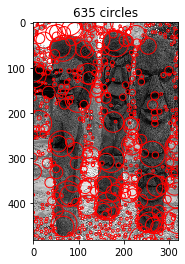

method:efficient
0.18572330474853516


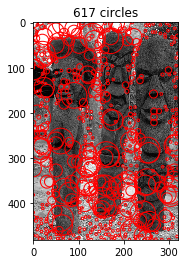

In [26]:
threshold = 0.06
run_detection(images[0],initial_sigma,level,k,threshold,size3)
run_detection_effi(images[0],initial_sigma,level,k,threshold,size3)

method: basic
0.5979931354522705


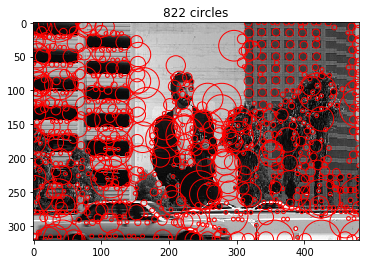

method:efficient
0.1778261661529541


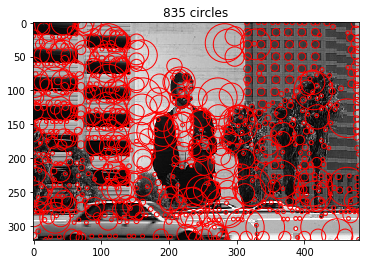

In [29]:
threshold = 0.04
run_detection(images[1],initial_sigma,level,k,threshold,size3)
run_detection_effi(images[1],initial_sigma,level,k,threshold,size3)

method: basic
0.5921542644500732


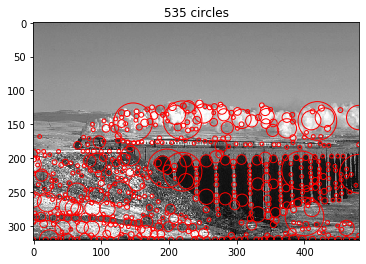

method:efficient
0.16283202171325684


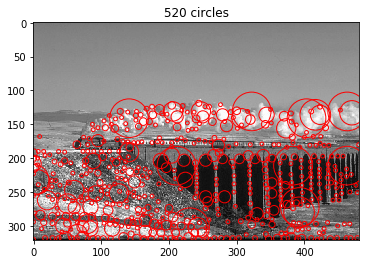

In [22]:
threshold = 0.1
run_detection(images[2],initial_sigma,level,k,threshold,size3)
run_detection_effi(images[2],initial_sigma,level,k,threshold,size3)

method: basic
0.6044752597808838


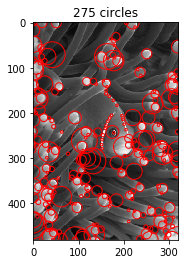

method:efficient
0.17967605590820312


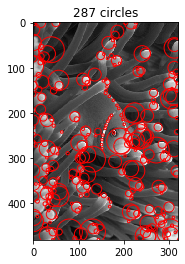

In [23]:
threshold = 0.1
run_detection(images[3],initial_sigma,level,k,threshold,size3)
run_detection_effi(images[3],initial_sigma,level,k,threshold,size3)

method: basic
0.6944241523742676


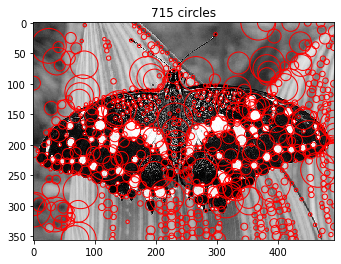

method:efficient
0.1988968849182129


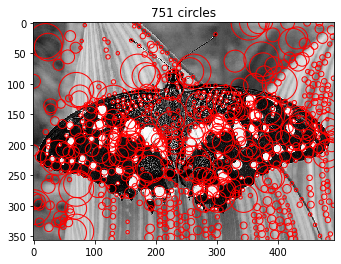

In [35]:
threshold = 0.02
run_detection(images[4],initial_sigma,level,k,threshold,size3)
run_detection_effi(images[4],initial_sigma,level,k,threshold,size3)

method: basic
1.2178561687469482


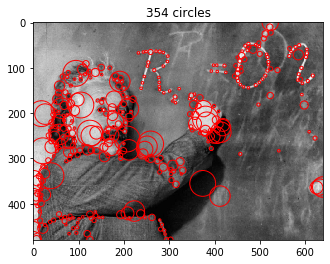

method:efficient
0.31272029876708984


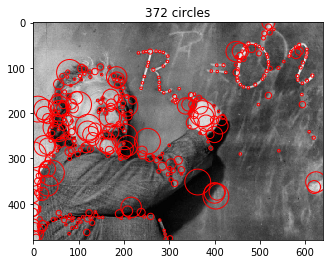

In [47]:
threshold = 0.1
run_detection(images[5],initial_sigma,level,k,threshold,size3)
run_detection_effi(images[5],initial_sigma,level,k,	threshold,size3)

method: basic
0.642409086227417


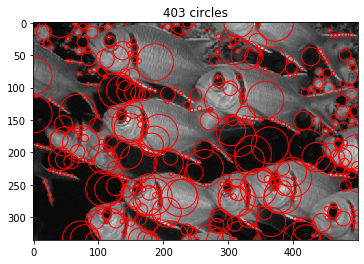

method:efficient
0.19240689277648926


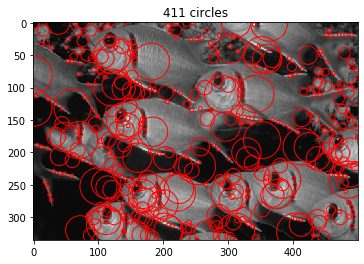

In [41]:
threshold = 0.15
run_detection(images[6],initial_sigma,level,k,threshold,size3)
run_detection_effi(images[6],initial_sigma,level,k,threshold,size3)

method: basic
0.45766496658325195


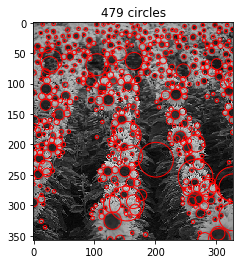

method:efficient
0.17693209648132324


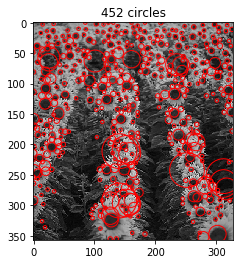

In [49]:
threshold = 0.2
run_detection(images[7],initial_sigma,level,k,threshold,size3)
run_detection_effi(images[7],initial_sigma,level,k,threshold,size3)

# difference-of-Gaussian pyramid

In [50]:
def build_Laplacian_DOG(image, initial_sigma, level, k):
    s = np.empty(level,dtype=object)
    h=image.shape[0]
    w=image.shape[1]
    for i in range(level):
        diff = scipy.ndimage.gaussian_filter(image,initial_sigma)-scipy.ndimage.gaussian_filter(image,initial_sigma*k)
        image = skimage.transform.resize(image,(int(h/(k**(i+1))),int(w/k**(i+1))))
        s[i] = (diff/(k-1))**2
    return s

In [51]:
def run_detection_DOG(img_name,initial_sigma,level,k,threshold,size3):
    path = img_dir+img_name+'.jpg'
    image= preprocess(path)
    start= time.time()
    scale_space = build_Laplacian_DOG (image,initial_sigma,level, k)
    non_sup_2d = non_max_sup_2d_effi (image,level,k,True,threshold)
    col_index,row_index,rad = non_max_sup_3d (non_sup_2d,initial_sigma,k, size3,threshold)
    end = time.time()
    print("method:DOG")
    print(end-start)
    show_all_circles(image,col_index,row_index,rad)

method:DOG
0.1573171615600586


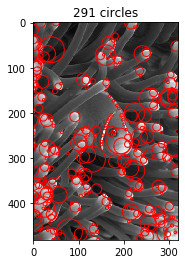

In [54]:
run_detection_DOG(images[3],initial_sigma,level,k,0.1,size3)